##Используем PCA для нашего датасета.

In [460]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets 
import pandas as pd
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA 
import seaborn as sns  
from sklearn.model_selection import train_test_split


In [461]:
data = pd.read_csv('insurance.csv')
data['sex'] = pd.factorize(data['sex'])[0]
data['smoker'] = pd.factorize(data['smoker'])[0]
Region_dummies = pd.get_dummies(data['region'])
data = pd.concat((data, Region_dummies), axis=1)
data = data.drop(['region'], axis=1)

In [462]:
data_stand = (data - data.mean(axis = 0))/data.std(axis = 0)
data_stand.head()

,age,sex,bmi,children,smoker,charges,northeast,northwest,southeast,southwest
0,-1.438227,-1.010141,-0.453151,-0.908274,-1.969850,0.298472,-0.565056,-0.566206,-0.611095,1.764821
1,-1.509401,0.989221,0.509431,-0.078738,0.507273,-0.953333,-0.565056,-0.566206,1.635183,-0.566206
2,-0.797655,0.989221,0.383164,1.580335,0.507273,-0.728402,-0.565056,-0.566206,1.635183,-0.566206
3,-0.441782,0.989221,-1.305043,-0.908274,0.507273,0.719574,-0.565056,1.764821,-0.611095,-0.566206
4,-0.512957,0.989221,-0.292447,-0.908274,0.507273,-0.776512,-0.565056,1.764821,-0.611095,-0.566206


Плсмотрим сколько главных компонент оставить.

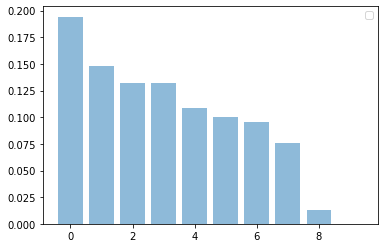

In [463]:
cov_mat = data_stand.cov()
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
plt.bar(range(0,len(eigen_vals)), var_exp, alpha=0.5,
        align='center')
plt.legend(loc='best')
plt.show()

Так как у нас изначально нет определённых классов, чтобы потом оценить PCA, проведём кластеризацию смоделировав, что разбиение в данном датасете было.

In [464]:
from sklearn.cluster import Birch
model = Birch(threshold=0.3)
model.fit(data)


Birch(threshold=0.3)

In [465]:
labels = pd.DataFrame({'labels':model.labels_})
data_new = data_stand
data_new = pd.concat((data_new, labels), axis=1)
data_new.head()

,age,sex,bmi,children,smoker,charges,northeast,northwest,southeast,southwest,labels
0,-1.438227,-1.010141,-0.453151,-0.908274,-1.969850,0.298472,-0.565056,-0.566206,-0.611095,1.764821,2
1,-1.509401,0.989221,0.509431,-0.078738,0.507273,-0.953333,-0.565056,-0.566206,1.635183,-0.566206,0
2,-0.797655,0.989221,0.383164,1.580335,0.507273,-0.728402,-0.565056,-0.566206,1.635183,-0.566206,0
3,-0.441782,0.989221,-1.305043,-0.908274,0.507273,0.719574,-0.565056,1.764821,-0.611095,-0.566206,2
4,-0.512957,0.989221,-0.292447,-0.908274,0.507273,-0.776512,-0.565056,1.764821,-0.611095,-0.566206,0


In [466]:
Y = data_new['labels']
X = data_new.drop(['labels'], axis=1)

Проведём классификацию методом К-ближайших на исходных данных оценим ошибку.

In [467]:
from sklearn.model_selection import train_test_split
N_train = int(len(data_stand) * 0.8)
N_test = len(data_stand) - N_train
X_train, X_test, Y_train, Y_test = train_test_split(data_stand, Y, 
                                                    train_size = N_train, test_size = N_test, 
                                                    stratify = Y, random_state = 15)

In [468]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, Y_train)

KNeighborsClassifier()

In [469]:
y_test_predict = knn.predict(X_test)
labels = pd.DataFrame({'labels':y_test_predict})
# for i in range(len(Y_test)):
#   if(list(Y_test)[i] != y_test_predict [i]):
#     print('*')

err_train = 1 - knn.score(X_train, Y_train)
err_test = 1 - knn.score(X_test, Y_test)
print('Ошибка на обучении: ' + str(err_train * 100) + '%')
print('Ошибка на тесте: ' + str(err_test * 100) + '%')

Ошибка на обучении: 4.953271028037387%
Ошибка на тесте: 7.0895522388059735%


Оставим 4 главных компоненты


In [470]:
pca_train = PCA(n_components = 4)
pca_train.fit(data_stand)
data_pca = pca_train.transform(data_stand)
data_pca = pd.DataFrame(data_pca)
data_pca.head()

,0,1,2,3
0,0.530430,-0.599232,1.777552,-0.201358
1,-0.390244,2.102187,-0.977230,-0.252131
2,-0.030278,1.851302,-0.685899,0.003456
3,-0.572928,-1.197947,-0.719708,1.608451
4,-1.278409,-0.383197,-0.809110,1.520054


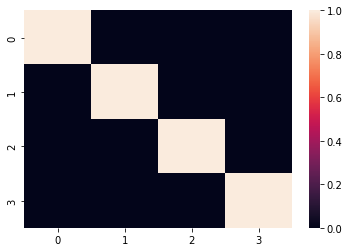

In [471]:
sns.heatmap(data_pca.corr())

Проведём классификацию методом К-ближайших на данных с пониженной размерностью и оценим ошибку.

In [472]:
from sklearn.model_selection import train_test_split
N_train = int(len(data_pca) * 0.8)
N_test = len(data_pca) - N_train
X_train, X_test, Y_train, Y_test = train_test_split(data_pca, Y, 
                                                    train_size = N_train, test_size = N_test, 
                                                    stratify = Y, random_state = 15)

In [473]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, Y_train)

KNeighborsClassifier()

In [474]:
y_test_predict = knn.predict(X_test)
labels = pd.DataFrame({'labels':y_test_predict})

err_train = 1 - knn.score(X_train, Y_train)
err_test = 1 - knn.score(X_test, Y_test)
print('Ошибка на обучении: ' + str(err_train * 100) + '%')
print('Ошибка на тесте: ' + str(err_test * 100) + '%')

Ошибка на обучении: 4.112149532710285%
Ошибка на тесте: 6.716417910447758%


Понижение размерности дало небольшой прирост в качестве классификации, значит в данной задаче имеет смысл использовать PCA.